## Purpose

**Abstract**: Find all the dips in Gaia FG dwarfs in ZTF DR14 photometry.

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import astropy.stats as astro_stats
from astropy.io import ascii
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [3]:
%%time 

#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 52.4 s, sys: 8.97 s, total: 1min 1s
Wall time: 1min 3s


In [4]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 6.68 s, sys: 1.21 s, total: 7.89 s
Wall time: 7.84 s


In [5]:
%%time

# compute gaia-ztf_object crossmatch table
_all_sky_object = _all_sky_object.compute()

CPU times: user 1h 34min 9s, sys: 1h 36min 30s, total: 3h 10min 39s
Wall time: 20min 44s


In [6]:
print (f"Number of unique sources: {len(_all_sky_object.index.unique())}")

Number of unique sources: 4833834


In [7]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 2min 54s, sys: 8.76 s, total: 3min 3s
Wall time: 3min 1s


In [8]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 35s, sys: 5.52 s, total: 1min 40s
Wall time: 1min 40s


## TAPE

In [9]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

## Time Series Functions

In [10]:
def peak_detector(times, dips, power_thresh=3, pk_2_pk_cut=30):
    """
    Run and compute dip detection algorithm on a light curve.
    
    Parameters:
    -----------
    times (array-like): Time values of the light curve.
    dips (array-like): Deviation values of the light curve.
    power_thresh (float): Threshold for the peak detection. Default is 3.
    pk_2_pk_cut (float): Minimum peak to peak separation. Default is 30 days.

    Returns:
    --------
    N_peaks (int): Number of peaks detected.
    dip_summary (dict): Summary of the dip. Including the peak location, the window start and end, the number of 1 sigma detections in the dip, the number of detections in the dip, the forward and backward duration of the dip, and the dip power.
    """

    if len(dips)==0:
        return None, None

    # Scipy peak finding algorithm
    pks, _ = find_peaks(dips, height=power_thresh, distance=pk_2_pk_cut) #TODO: is 100 days peak separation too aggresive?

    # Reverse sort the peak values
    pks = np.sort(pks)[::-1]
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    # Number of peaks
    N_peaks = len(t_pks)
    
    dip_summary = {}
    for i, (time_ppk, ppk) in enumerate(zip(t_pks, p_pks)):        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            "dip_power":ppk,
        }
                
    return N_peaks, dip_summary

In [11]:
def prepare_lc(time, mag, mag_err, flag, band, band_of_study='r', flag_good=0):
    """
    Prepare the light curve for analysis - specifically for the ZTF data.
    
    Parameters:
    -----------
    time (array-like): Input time values.
    mag (array-like): Input magnitude values.
    mag_err (array-like): Input magnitude error values.
    flag (array-like): Input flag values.
    band (array-like): Input band values.
    band_of_study (str): Band to study. Default is 'r' band
    flag_good (int): Flag value for good detections. Default is 0 (see ZTF documentation)

    Returns:
    --------
    time (array-like): Output time values.
    mag (array-like): Output magnitude values.
    mag_err (array-like): Output magnitude error values.
    """
    # Selection and preparation of the light curve (default selection on )
    rmv = (flag == flag_good) & (mag_err>0) & (band==band_of_study) & (~np.isnan(time)) & (~np.isnan(mag)) & (~np.isnan(mag_err)) # remove nans!
    
    time, mag, mag_err = time[rmv], mag[rmv], mag_err[rmv]
    
    # sort time
    srt = time.argsort()

    # Remove repeated entries
    time, mag, mag_err = time[srt], mag[srt], mag_err[srt]
    ts = abs(time - np.roll(time, 1)) > 1e-5
    
    if len(time[ts])>0:
        return time[ts], mag[ts], mag_err[ts]
    else:
        return None, None, None

In [12]:
def deviation(mag, mag_err, R, S):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.
    R (float): Biweight location of the light curve (global).
    S (float): Biweight scale of the light curve (global).

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    return (mag - R) / np.sqrt(mag_err**2 + S**2)

## Test Peak Finding

In [15]:
lc = ascii.read("https://ztf.snad.space/dr17/csv/741107200001800")

In [16]:
dev = deviation(lc['mag'], lc['magerr'],
                astro_stats.biweight_location(lc['mag']), 
               astro_stats.biweight_scale(lc['mag']))

In [17]:
npeak, peak_dict = peak_detector(lc['mjd'], dev, power_thresh=2)

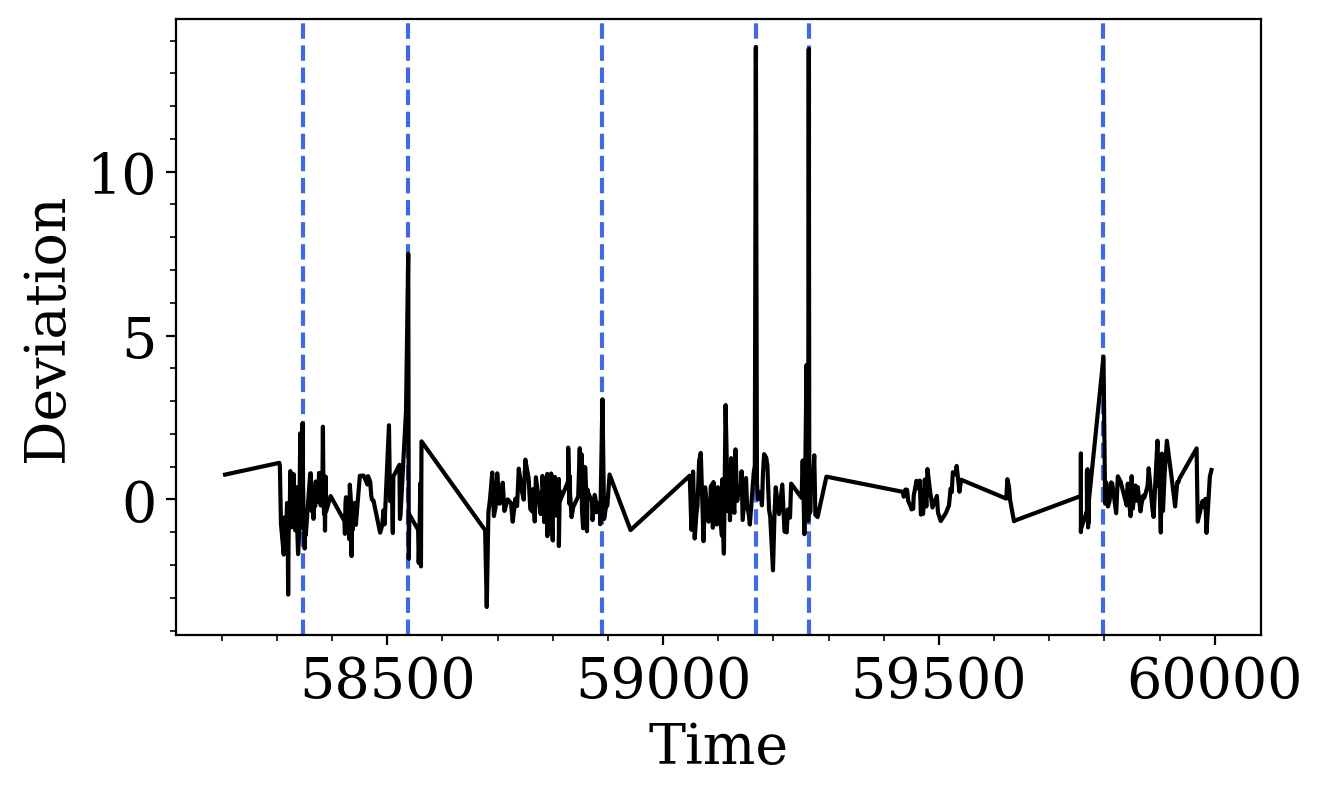

In [18]:
plt.figure(figsize=(7,4))

for i in range(npeak):
    plt.axvline(peak_dict[f'dip_{i}']['peak_loc'], ls='--', color='royalblue')

plt.plot(lc['mjd'], dev, color='k')
plt.ylabel("Deviation")
plt.xlabel("Time")
plt.minorticks_on()

## Initialize TAPE

In [13]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35387 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35387/status,
Dashboard: http://127.0.0.1:35387/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45897,Workers: 12
Dashboard: http://127.0.0.1:35387/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:39290,Total threads: 8
Dashboard: http://127.0.0.1:45980/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:42127,


In [14]:

# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


### Temporary table

In [607]:
temp = pd.DataFrame({"ps1_id": [np.nan],
                     "dip_loc": [np.nan],
                     "dip_power": [np.nan]}).to_csv("temp/alias_dips.csv", index=False)

2024-01-18 23:25:33,621 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 242)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
67279027269795840  42.302768  15.890168       8.260783  ...       5    0    59
67279717740314624  42.203897  15.863656       0.542655  ...       5    0    59
67284408012374016  42.066736  15.879176       2.245057  ...       5    0    59
67311878849691648  42.012738  15.995951       0.511279  ...       5    0    59
67361639992655872  42.761615  16.235110       0.625406  ...       5    0    59
67364011796070400  42.717452  16.285669       0.355854  ...       5    0    59
67366280113422336  42.873497  16.325146       1.137564  ...       5    0    59
67373364569702400  42.611270  16.387112       0.431886  ...       5    0 

2024-01-18 23:26:15,089 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 427)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
102457013635645440  59.073915  19.493821       0.604497  ...       5    0    91
102458393016401920  59.141161  19.555069       0.419989  ...       5    0    91
102459548652011520  59.019213  19.550363       0.468409  ...       5    0    91
102459415088594944  59.034430  19.542427       0.782424  ...       5    0    91
102469801649111040  58.955999  19.685712       0.577941  ...       5    0    91
102480108647874560  59.381387  19.773047       0.305426  ...       5    0    91
102487762380259328  59.246916  19.805688       0.399007  ...       5    0    91
102489256726888448  59.292481  19.874959       0.540535  ...    

2024-01-18 23:27:01,833 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 7)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                     ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                        ...                   
1971812300750848  46.476977  2.462577       0.346165  ...       5    0     1
1973942252208128  46.419761  2.490481       0.662282  ...       5    0     1
1975094981165056  46.527661  2.499800       0.669876  ...       5    0     1
2017890282766336  46.160522  2.710411       0.717794  ...       5    0     1
2020597877964800  46.249919  2.769677       0.434071  ...       5    0     1
2034784255606784  46.240794  2.827621       0.803864  ...       5    0     1
2035094550216704  46.260061  2.852951       3.623293  ...       5    0     1
2058786193801216  46.959643  2.879802       0.756049  ...       5    0     1
2062084481220608

2024-01-18 23:27:34,384 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 152)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
42791958111846400  40.868557  8.551753       0.741172  ...       5    0    38
42812063436767232  40.941879  8.684330       3.180741  ...       5    0    38
42827536220028928  40.696814  8.725978       0.566060  ...       5    0    38
42883372975915008  41.179311  8.977414       0.988106  ...       5    0    38
42886829044662272  41.379782  9.060487       1.187876  ...       5    0    38
42925320935833600  40.454641  8.723888       0.849561  ...       5    0    38
42930859128389632  40.571942  8.835465       0.786241  ...       5    0    38
42939474505629696  40.472318  8.905137       1.172434  ...       5    0    38
4294

2024-01-18 23:28:46,014 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 79)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
22259136196509696  50.880302  8.642746       0.718182  ...       5    0    19
22261326843740160  50.822549  8.683558       0.515152  ...       5    0    19
22263435886592000  50.726943  8.657982       0.619134  ...       5    0    19
22275471978790912  50.460989  8.652554       0.786082  ...       5    0    19
22284145581359104  50.383702  8.724473       0.624710  ...       5    0    19
22292254978736128  50.559806  8.763781       0.515881  ...       5    0    19
22294006314565632  50.741388  8.794735       0.404908  ...       5    0    19
22317187486187520  50.967514  8.841392       0.903942  ...       5    0    19
22318

2024-01-18 23:29:15,134 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 230)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
63899650704277504  42.291954  13.361477       0.946277  ...       5    0    56
63909257807921152  42.221224  13.453720       0.486404  ...       5    0    56
63917763550248960  42.459867  13.538763       0.794530  ...       5    0    56
63948562651676672  42.179275  13.605438       0.609672  ...       5    0    56
63960956752887808  42.177426  13.728189       0.386568  ...       5    0    56
63968850256855040  42.577286  13.667388       0.600588  ...       5    0    56
64012267611488256  42.246345  13.876823       0.367216  ...       5    0    56
64012655660105728  42.259731  13.884537       0.588438  ...       5    0 

2024-01-18 23:30:00,325 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 18)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                     ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                        ...                   
5076384384811008  47.024541  3.121870       0.487053  ...       5    0     4
5077660082372608  46.981123  3.117712       0.552559  ...       5    0     4
5080406474883072  47.091531  3.172137       0.860243  ...       5    0     4
5082005230321664  47.061221  3.185791       0.629156  ...       5    0     4
5101016743673856  47.315316  3.394502       0.676692  ...       5    0     4
5109277760946176  46.989065  3.305627       0.404663  ...       5    0     4
5126599657652224  47.146326  3.439556       0.387216  ...       5    0     4
5127012523966464  47.154072  3.466121       0.802075  ...       5    0     4
513436312141824

2024-01-18 23:30:09,461 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 75)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
21118596524539904  49.329347  7.352420       0.436816  ...       5    0    18
21129832880406528  49.454562  7.413544       0.860561  ...       5    0    18
21131569548754944  49.394455  7.419477       0.786863  ...       5    0    18
21140255390302208  49.264546  7.506797       0.591820  ...       5    0    18
21173252923588608  49.134031  7.621739       0.703275  ...       5    0    18
21177389174226944  49.193630  7.678094       0.708128  ...       5    0    18
21177351819755520  49.198433  7.672607       0.733540  ...       5    0    18
21187034748026880  49.721373  7.647491       0.833211  ...       5    0    18
21198

2024-01-18 23:30:26,153 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 33)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                     ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                        ...                   
9331827617562624  42.803317  3.319642       0.938341  ...       5    0     8
9337132682313728  42.722438  3.298599       1.503056  ...       5    0     8
9341290059661312  42.716915  3.415045       0.650010  ...       5    0     8
9367219230212096  43.338794  3.478606       0.382509  ...       5    0     8
9377442422587392  43.390717  3.484465       1.737486  ...       5    0     8
9389477793366016  43.293322  3.624049       1.754892  ...       5    0     8
9392637744250880  43.354574  3.654454       0.444705  ...       5    0     8
9409250547728384  43.075300  3.659377       0.457670  ...       5    0     8
940949226966220

2024-01-18 23:31:12,987 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 602)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
124496385813774336  48.868323  21.918600       0.589296  ...       5    0   110
124504610843918336  49.145110  21.971826       0.835068  ...       5    0   110
124510704148414464  49.010597  22.041811       0.374846  ...       5    0   110
124516948053590016  49.022964  22.128656       0.429747  ...       5    0   110
124529693801054208  48.608971  22.042274       0.468400  ...       5    0   110
124536736465289216  48.887531  22.086284       0.817328  ...       5    0   110
124547529420308480  48.816354  22.220798       0.750376  ...       5    0   110
124549406702698496  48.912776  22.235224       0.854218  ...    

2024-01-18 23:31:43,711 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 69)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
19429013051146240  52.775143  6.730112       0.404706  ...       5    0    17
19435500204982272  52.756899  6.777397       0.514224  ...       5    0    17
19440019429130240  52.893618  6.764572       0.446321  ...       5    0    17
19441655052500992  52.885508  6.784797       1.263569  ...       5    0    17
19474548499939328  52.556226  7.028066       0.631375  ...       5    0    17
19477886813601792  52.728072  6.963583       1.161615  ...       5    0    17
19481937924063232  52.750631  7.036297       0.493451  ...       5    0    17
19492219710865408  53.094112  6.892906       0.973191  ...       5    0    17
19492

2024-01-18 23:31:58,360 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 105)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
29582859303911424  47.268036   9.297638       0.506461  ...       5    0    26
29587591086997504  47.331103   9.372600       0.330041  ...       5    0    26
29601563664187392  46.829922   9.302555       0.314268  ...       5    0    26
29605280270516224  46.984520   9.384226       0.319445  ...       5    0    26
29618846511923200  46.967123   9.429730       0.423959  ...       5    0    26
29622188323635200  47.149860   9.507930       0.378136  ...       5    0    26
29670922424156160  47.214204   9.588920       1.669103  ...       5    0    26
29676431940255744  47.216481   9.665077       2.623249  ...       5    0 

2024-01-18 23:32:24,882 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 458)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
105062341342658560  64.351043  21.780296       0.728260  ...       5    0    93
105064608221364224  64.321096  21.830886       0.378224  ...       5    0    93
105067105224753152  64.463581  21.894322       0.459250  ...       5    0    93
105067253594062848  64.391884  21.845065       0.409542  ...       5    0    93
105067927782293504  64.356476  21.872489       0.707177  ...       5    0    93
105068208326705152  64.370653  21.893305       0.382629  ...       5    0    93
105069490428968960  64.246457  21.801971       1.415557  ...       5    0    93
105070242715140096  64.264605  21.840573       0.431902  ...    

2024-01-18 23:32:53,584 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 185)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
52076487750189056  38.684670  11.518579       0.521363  ...       5    0    46
52093639039385600  38.791221  11.659286       3.627406  ...       5    0    46
52140154688634880  38.718732  11.934789       0.406586  ...       5    0    46
52161791425249280  39.211270  11.937064       0.557075  ...       5    0    46
52201751054385152  39.162227  12.169726       0.320445  ...       5    0    46
52224401990483968  38.289700  11.885036       0.473805  ...       5    0    46
52232045958529024  38.501142  11.918320       0.698780  ...       5    0    46
52245756031008768  38.543042  12.094064       0.399138  ...       5    0 

2024-01-18 23:33:17,632 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 49)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
13794068358234112  45.717464  5.450318       0.738275  ...       5    0    12
13796409631309824  45.699773  5.498117       1.474585  ...       5    0    12
13825907596722176  45.827070  5.755970       0.594367  ...       5    0    12
13850128691494912  45.777954  5.795988       1.049015  ...       5    0    12
13854099824967680  45.606417  5.784103       0.513247  ...       5    0    12
13854748721545216  45.624091  5.804034       0.408948  ...       5    0    12
13865556226605056  45.981273  5.753876       0.432757  ...       5    0    12
13872589189414912  46.005778  5.804897       2.135341  ...       5    0    12
13882

2024-01-18 23:34:03,849 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 460)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
105202791428915200  64.040316  22.099608       0.511233  ...       5    0    93
105204181685501952  63.918013  22.104812       0.769140  ...       5    0    93
105205509006557184  63.987842  22.164820       0.946653  ...       5    0    93
105205465255772160  63.995529  22.156689       0.389372  ...       5    0    93
105206393362972672  64.034778  22.141767       0.788431  ...       5    0    93
105207767714758656  64.101354  22.202383       0.393390  ...       5    0    93
105208212008992768  64.048695  22.183346       0.661209  ...       5    0    93
105208245714419712  64.066400  22.187583       0.798260  ...    

2024-01-18 23:34:33,047 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 57)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
16062684944400384  44.466059  6.790289       2.224143  ...       5    0    14
16068873702866944  44.492455  6.874713       0.506009  ...       5    0    14
16085951071649792  44.181091  6.861502       0.561561  ...       5    0    14
16086558151016448  44.130732  6.877859       0.788592  ...       5    0    14
16090710507782144  43.993421  6.880750       0.828209  ...       5    0    14
16100410334904320  44.296350  6.986959       0.400298  ...       5    0    14
16100860719267840  44.272123  6.993299       0.877344  ...       5    0    14
16103494364692480  44.333199  7.003923       0.772443  ...       5    0    14
16117

2024-01-18 23:34:41,947 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 18)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                     ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                        ...                   
5076384384811008  47.024541  3.121870       0.487053  ...       5    0     4
5077660082372608  46.981123  3.117712       0.552559  ...       5    0     4
5080406474883072  47.091531  3.172137       0.860243  ...       5    0     4
5082005230321664  47.061221  3.185791       0.629156  ...       5    0     4
5101016743673856  47.315316  3.394502       0.676692  ...       5    0     4
5109277760946176  46.989065  3.305627       0.404663  ...       5    0     4
5126599657652224  47.146326  3.439556       0.387216  ...       5    0     4
5127012523966464  47.154072  3.466121       0.802075  ...       5    0     4
513436312141824

2024-01-18 23:35:19,007 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 651)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
146126781882040320  35.082655  12.318360       0.720645  ...       5    0   129
146129288393916416  35.080843  12.379404       0.690476  ...       5    0   129
146142248512258048  35.142462  12.445181       2.122104  ...       5    0   129
146144820627243008  35.286486  12.504355       0.597276  ...       5    0   129
146167190800826368  35.395986  12.472310       0.366977  ...       5    0   129
146168024393580544  35.414331  12.493899       0.778402  ...       5    0   129
146171854246117376  35.443547  12.550617       0.418113  ...       5    0   129
146185675014668288  35.600929  12.653197       0.406230  ...    

2024-01-18 23:35:35,935 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 648)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
145274850825469952  35.274631  11.194602       1.128377  ...       5    0   129
145282880094863360  35.023043  11.078342       0.576395  ...       5    0   129
145302321104945152  35.221929  11.304879       1.796025  ...       5    0   129
145323909665783808  35.453727  11.298899       1.131994  ...       5    0   129
145326582184017920  35.552032  11.344018       0.606570  ...       5    0   129
145328506732019712  35.488580  11.363282       0.346944  ...       5    0   129
145332550762496000  35.674678  11.365209       0.343442  ...       5    0   129
145339144082554880  35.627579  11.401571       0.328022  ...    

2024-01-18 23:36:21,271 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 438)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
103443392876249088  58.758852  21.135303       0.455656  ...       5    0    91
103445297396449280  58.666431  21.168242       0.376544  ...       5    0    91
103450102391111680  58.833972  21.258289       0.470361  ...       5    0    91
103450208066600960  58.800540  21.261400       0.413215  ...       5    0    91
103453695714263040  58.569483  21.221772       0.281867  ...       5    0    91
103453840761683968  58.554311  21.229239       0.267274  ...       5    0    91
103458975667716096  58.721700  21.340612       0.517054  ...       5    0    91
103464049060085760  58.976783  21.305397       0.551984  ...    

2024-01-18 23:36:38,999 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 417)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
101757694930583552  58.113808  19.253947       0.985585  ...       5    0    90
101758025504653312  58.103270  19.268432       0.680270  ...       5    0    90
101759918318551040  58.058950  19.295307       0.904681  ...       5    0    90
101765410646392832  57.923362  19.331068       1.157045  ...       5    0    90
101774901152579584  58.154711  19.444953       0.505224  ...       5    0    90
101779459509583872  58.263996  19.524103       2.444322  ...       5    0    90
101791709049913344  57.839615  19.400571       0.586544  ...       5    0    90
101800931632349184  57.750273  19.508870       0.866736  ...    

2024-01-18 23:36:53,669 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 589)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
123154098152275968  52.470891  21.942861       1.301926  ...       5    0   109
123171063394729984  52.659902  22.071318       0.443150  ...       5    0   109
123186197869625344  52.340537  22.010142       0.327799  ...       5    0   109
123191016818737152  52.150871  22.022654       0.548401  ...       5    0   109
123194820909858816  52.249342  22.074956       0.515293  ...       5    0   109
123201888999964672  52.411076  22.156732       0.927312  ...       5    0   109
123206738974343168  52.461790  22.238248       0.902167  ...       5    0   109
123211888195534848  52.360817  22.222531       0.661051  ...    

2024-01-18 23:37:10,810 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 202)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
56858789260820480  42.894877  11.459296       0.530365  ...       5    0    50
56863076984553472  42.937900  11.530034       0.415521  ...       5    0    50
56864436798881792  43.017262  11.589088       0.362949  ...       5    0    50
56872585572384768  42.966429  11.636878       0.370864  ...       5    0    50
56897991318962176  42.808343  11.685480       0.399707  ...       5    0    50
56912871484817408  42.938733  11.821077       0.516550  ...       5    0    50
56922698869112832  42.752816  11.889266       0.644919  ...       5    0    50
56924818523553792  42.898173  11.923218       0.706957  ...       5    0 

2024-01-18 23:37:35,732 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 213)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
59975304122204160  50.089831  14.119089       0.444816  ...       5    0    53
59976532143112192  50.221162  14.131010       0.982073  ...       5    0    53
59999429184192512  49.687503  14.151051       1.129767  ...       5    0    53
60003516927705088  49.739599  14.223208       0.665961  ...       5    0    53
60014569283649536  49.951667  14.348317       0.970968  ...       5    0    53
60015194448855040  49.989346  14.345128       0.728960  ...       5    0    53
60015429241798656  49.993860  14.372123       0.514560  ...       5    0    53
60041103147008000  50.283225  14.412683       0.705565  ...       5    0 

2024-01-18 23:37:52,384 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 497)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
107805765208637440  61.882163  23.369146       1.401428  ...       5    0    95
107806785154318336  61.896296  23.405895       0.344206  ...       5    0    95
107809870190739456  61.944718  23.424999       0.617978  ...       5    0    95
107811237642895360  61.984966  23.499590       0.539861  ...       5    0    95
107813903991308288  61.773996  23.422040       0.330454  ...       5    0    95
107814146833121280  61.806416  23.439153       0.801646  ...       5    0    95
107817939373129728  61.792289  23.538302       0.693593  ...       5    0    95
107821343684165632  61.831564  23.586066       0.764610  ...    

2024-01-18 23:38:14,692 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 517)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
111977031360577536  51.444752  18.432875       0.655000  ...       5    0    99
111987912194654208  51.510104  18.564038       0.725336  ...       5    0    99
111991079867252736  51.520775  18.634482       0.580356  ...       5    0    99
111995664648372224  51.175032  18.495426       0.380923  ...       5    0    99
111999563904057344  51.236253  18.529003       0.584546  ...       5    0    99
112013332625489920  51.303347  18.630178       0.369561  ...       5    0    99
112013711912206336  51.315342  18.654553       0.547097  ...       5    0    99
112019948309577728  51.259644  18.674568       3.287334  ...    

2024-01-18 23:38:41,927 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 564)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
118864526622851072  48.697067  19.310353       0.297690  ...       5    0   105
118874575671918592  49.037771  19.446088       0.583795  ...       5    0   105
118876236708577280  49.193204  19.466870       1.559457  ...       5    0   105
118881003350523904  48.970577  19.468318       1.169135  ...       5    0   105
118889521008869376  48.745054  19.390117       0.320767  ...       5    0   105
118891088973922304  48.658996  19.405061       0.569419  ...       5    0   105
118901610561667072  48.698552  19.505158       0.443405  ...       5    0   105
118912321232830464  48.900881  19.601734       0.440497  ...    

2024-01-18 23:38:57,287 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 350)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
91137933465092096  61.857666  16.503142       0.444808  ...       5    0    80
91141432718393344  61.846236  16.529615       0.578939  ...       5    0    80
91143907592634368  61.820304  16.587798       1.216484  ...       5    0    80
91166829635960832  61.676612  16.624695       0.391951  ...       5    0    80
91167690827235328  61.758792  16.593518       1.016356  ...       5    0    80
91169960339963904  61.725427  16.643122       0.355161  ...       5    0    80
91175790170865664  61.607797  16.705698       0.381430  ...       5    0    80
91180665269125120  61.913096  16.684542       0.721328  ...       5    0 

2024-01-18 23:39:08,404 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 725)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
163540509078323200  41.481472  16.443812       3.098058  ...       5    0   145
163545299220955136  41.570517  16.528570       0.492755  ...       5    0   145
163548611139862528  41.336863  16.487972       2.548240  ...       5    0   145
163548360614084608  41.383235  16.493610       0.724495  ...       5    0   145
163571404971704320  41.691755  16.759503       1.341984  ...       5    0   145
163589329686364160  41.275126  16.757081       0.413637  ...       5    0   145
163598395246641152  41.580568  16.867618       0.429097  ...       5    0   145
163625127525744640  42.000537  16.828929       0.545793  ...    

2024-01-18 23:39:27,637 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 605)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
124694769489149952  49.258592  22.097463       0.852130  ...       5    0   110
124709946951467008  49.215719  22.275168       0.611500  ...       5    0   110
124715961856032768  49.461227  22.291370       0.490890  ...       5    0   110
124716970284154880  49.539181  22.349870       1.816444  ...       5    0   110
124727093106835456  49.322174  22.422576       0.590798  ...       5    0   110
124730393109725184  49.055500  22.261434       0.996658  ...       5    0   110
124746203983249408  49.216303  22.353677       1.000528  ...       5    0   110
124746689335525376  49.240416  22.396323       0.632079  ...    

2024-01-18 23:39:47,324 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 370)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
94438309824036864  61.519567  18.620992       0.994456  ...       5    0    83
94439145711075328  61.519145  18.663260       0.702509  ...       5    0    83
94445093343199232  61.502105  18.681052       0.697673  ...       5    0    83
94454298502496256  61.711007  18.767129       0.345676  ...       5    0    83
94456447806472192  61.664498  18.796891       0.416562  ...       5    0    83
94459035796897792  61.828383  18.872641       1.424648  ...       5    0    83
94461144940412928  61.772863  18.897611       0.430483  ...       5    0    83
94470021870256128  61.693675  18.992025       1.154802  ...       5    0 

2024-01-18 23:40:17,170 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 176)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
49543655882489856  39.356954   9.711771       0.975529  ...       5    0    44
49543805849829376  39.391750   9.723437       0.404002  ...       5    0    44
49546120078032896  39.496323   9.769850       0.787881  ...       5    0    44
49547831450533888  39.489210   9.798269       1.743597  ...       5    0    44
49560906899652608  39.564604   9.855431       0.816556  ...       5    0    44
49561465111183360  39.540231   9.876475       0.420854  ...       5    0    44
49565065199747072  39.618951   9.913874       0.424772  ...       5    0    44
49567579546583040  39.530271   9.904413       0.505445  ...       5    0 

2024-01-18 23:40:28,056 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 489)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
107244481182433280  62.553196  22.740313       0.996932  ...       5    0    95
107246563192995840  62.654440  22.775708       1.086347  ...       5    0    95
107249440863027200  62.623987  22.843993       0.865978  ...       5    0    95
107250279128236032  62.643076  22.868730       0.461949  ...       5    0    95
107252167357759488  62.560675  22.822460       0.544761  ...       5    0    95
107253028477730816  62.444447  22.808803       1.153925  ...       5    0    95
107253976646287360  62.435499  22.854260       0.850231  ...       5    0    95
107254079838748672  62.497174  22.839256       0.521457  ...    

2024-01-18 23:40:51,813 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 98)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
27584750910701568  47.099834  7.808448       0.490919  ...       5    0    24
27584955294941184  47.139406  7.826251       0.591319  ...       5    0    24
27591211900469248  47.151372  7.911733       0.760591  ...       5    0    24
27598417484054528  47.102251  7.975348       1.001666  ...       5    0    24
27616034705899520  47.251293  8.117919       0.434588  ...       5    0    24
27623166272602112  46.944504  8.034604       0.613672  ...       5    0    24
27633485074137088  46.909734  8.106738       1.664979  ...       5    0    24
27635697632411648  46.877582  8.149222       0.739215  ...       5    0    24
27642

2024-01-18 23:41:07,816 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 667)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
150590838638903296  38.003711  14.550842       0.399299  ...       5    0   133
150600395079548928  37.855144  14.618685       0.404068  ...       5    0   133
150605950556831744  38.002089  14.739916       0.709017  ...       5    0   133
150606688322322432  37.968017  14.777800       0.721662  ...       5    0   133
150629686337077248  37.873137  14.767643       1.823514  ...       5    0   133
150629807221112832  37.921743  14.753757       0.577870  ...       5    0   133
150656504133844992  38.027449  15.008826       0.356894  ...       5    0   133
150667680729268224  38.439624  14.987320       0.458201  ...    

2024-01-18 23:41:16,723 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 501)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
108090090059726848  50.660919  14.597673       1.037676  ...       5    0    96
108094778284965888  50.680105  14.663990       1.276298  ...       5    0    96
108095719482589184  50.553738  14.606682       0.569075  ...       5    0    96
108097276085272576  50.574815  14.651204       1.113844  ...       5    0    96
108107278367850496  50.757209  14.744267       1.112390  ...       5    0    96
108126032787144704  50.539959  14.724268       0.601858  ...       5    0    96
108150794267656192  50.481635  14.936069       2.481522  ...       5    0    96
108155657240182784  50.581969  15.053123       0.497633  ...    

2024-01-18 23:41:35,104 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 758)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
170300032510066688  42.925633  20.293511       0.328793  ...       5    0   151
170321805490257920  42.939244  20.436143       0.848318  ...       5    0   151
170363557433573376  43.240358  20.466639       0.375643  ...       5    0   151
170368641311703040  43.385295  20.575428       0.453765  ...       5    0   151
170372248710938624  43.118255  20.540318       1.913143  ...       5    0   151
170373595065745408  43.190182  20.598689       0.929756  ...       5    0   151
170380075793907712  43.243642  20.713145       0.480212  ...       5    0   151
170383892484718592  43.419673  20.700133       0.699375  ...    

2024-01-18 23:41:49,098 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 672)
Function:  subgraph_callable-5db68a45-c7bb-4f98-bf27-5fff4824
args:      ('empty2',                       ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                           ...                   
152018882884796416  36.858119  14.752183       0.747661  ...       5    0   135
152020844002934784  36.774532  14.768468       1.896965  ...       5    0   135
152026507949113344  36.673607  14.820099       0.621351  ...       5    0   135
152026915367026688  36.615815  14.826702       0.486626  ...       5    0   135
152042877734617088  36.258468  14.770171       1.382498  ...       5    0   135
152061338145783808  36.425271  14.971253       0.458475  ...       5    0   135
152063930234044416  36.642137  15.017731       0.384788  ...       5    0   135
152084844489211904  37.122396  14.980841       0.355067  ...    

In [549]:
#dpm = dask.dataframe.read_csv("temp/alias_dips.csv")

#%%time
#dask.dataframe.concat([dpm, le]).compute().to_csv("temp/alias_dips.csv", index=False)

## Batch Light Curve Calculation

In [561]:
def batch_lc_calculate_V2(time, mag, mag_err, flag, band):
    
    try:
        time, mag, mag_err = prepare_lc(time, mag, mag_err, flag, band,  band_of_study='r', flag_good=0)

        if time is not None:
            # Calculate deviation
            dev = deviation(mag, mag_err,
                        astro_stats.biweight_location(mag), 
                       astro_stats.biweight_scale(mag))

            # detect peaks
            npeak, peak_dict = peak_detector(time, dev, power_thresh=1)

            source = 1

            if npeak>0:
                # append variables and store...
                X, Y, Z = [], [], []
                for i in range(npeak):
                    X.append(peak_dict[f'dip_{i}']['peak_loc'])
                    Y.append(peak_dict[f'dip_{i}']['dip_power'])
                    Z.append(source) # this is the PS1 ID!

                # Store dataframe
                data_store = pd.DataFrame({"ps1_id":Z, "dip_loc":X, "dip_power":Y})
                
                # Open csv template
                template = dask.dataframe.read_csv("temp/alias_dips.csv")                    
                dask.dataframe.concat([template, data_store]).compute().to_csv("temp/alias_dips.csv", index=False)

                return pd.Series({"empy1":1.0, "empty2":1.0})
        else:
            pd.Series({"empy1":1.0, "empty2":1.0})
            print ("skipping")
    except:
        return pd.Series({"empy1":1.0, "empty2":1.0})


In [562]:
def batch_lc_calculate(time, mag, mag_err, flag, band):
    
    try:
        time, mag, mag_err = prepare_lc(time, mag, mag_err, flag, band,  band_of_study='r', flag_good=0)

        if time is not None:
            # Calculate deviation
            dev = deviation(mag, mag_err,
                        astro_stats.biweight_location(mag), 
                       astro_stats.biweight_scale(mag))

            # detect peaks
            npeak, peak_dict = peak_detector(time, dev, power_thresh=1)

            source = 1

            if npeak>0:
                # append variables and store...
                X, Y, Z = [], [], []
                for i in range(npeak):
                    X.append(peak_dict[f'dip_{i}']['peak_loc'])
                    Y.append(peak_dict[f'dip_{i}']['dip_power'])
                    Z.append(source) # this is the PS1 ID!

                # Store dataframe
                data_store = pd.DataFrame({"ps1_id":Z, "dip_loc":X, "dip_power":Y})
                
                try:
                    # Open csv template
                    template = pd.read_csv("temp/alias_dips.csv")
                    data_store.seek(0)

                    # concatenate tables and store
                    pd.concat([template, data_store]).to_csv("temp/alias_dips.csv", index=False)
                    return pd.Series({"empy1":1.0, "empty2":1.0})
                except:
                    return pd.Series({"empy1":1.0, "empty2":1.0})
        else:
            pd.Series({"empy1":1.0, "empty2":1.0})
            print ("skipping")
    except:
        return pd.Series({"empy1":1.0, "empty2":1.0})


In [563]:
my_meta = pd.DataFrame(columns=["empty1", "empty2"], dtype=float)

In [564]:
%%time 
calc = ens.batch(batch_lc_calculate_V2,
                'mjd_ztf_source', 'mag_ztf_source',
                 'magerr_ztf_source', 'catflags_ztf_source',
                 'band_ztf_source',
                use_map=True,
                 meta=my_meta, 
                compute=False)

Using generated label, result_2, for a batch result.
CPU times: user 5.53 s, sys: 1.05 s, total: 6.58 s
Wall time: 5.97 s


In [565]:
%%time
ens.assign(table='object', empty1=calc['empty1'], empty2=calc['empty2'])

CPU times: user 12.1 s, sys: 2.88 s, total: 15 s
Wall time: 14 s


In [581]:
%%time
test_table = ens.object.head(10_000, npartitions=1_000)

2024-01-18 23:16:07,604 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 57)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
16062684944400384  44.466059  6.790289       2.224143  ...       5    0    14
16068873702866944  44.492455  6.874713       0.506009  ...       5    0    14
16085951071649792  44.181091  6.861502       0.561561  ...       5    0    14
16086558151016448  44.130732  6.877859       0.788592  ...       5    0    14
16090710507782144  43.993421  6.880750       0.828209  ...       5    0    14
16100410334904320  44.296350  6.986959       0.400298  ...       5    0    14
16100860719267840  44.272123  6.993299       0.877344  ...       5    0    14
16103494364692480  44.333199  7.003923       0.772443  ...       5    0    14
16117

2024-01-18 23:17:47,063 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 244)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
67835511124787200  45.699385  15.105313       1.146558  ...       5    0    60
67840647247167488  45.776531  15.219974       0.415807  ...       5    0    60
67860451781771264  45.892858  15.411428       0.627359  ...       5    0    60
67862490033160192  45.779980  15.362458       0.313785  ...       5    0    60
67866833075568640  45.860410  15.433405       0.636974  ...       5    0    60
67870365237379072  45.857417  15.533256       0.573287  ...       5    0    60
67882666279567360  45.383679  15.426701       0.297889  ...       5    0    60
67888547163537408  45.727038  15.431548       3.606891  ...       5    0 

2024-01-18 23:19:19,222 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 55)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia  dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                         ...                   
15495054311292928  46.368792  7.371509       0.885283  ...       5    0    13
15527719785725952  46.109481  7.476528       2.655882  ...       5    0    13
15539340016877568  46.489890  7.617518       0.421925  ...       5    0    13
15539695509307392  46.569448  7.622505       0.749758  ...       5    0    13
15542255515336704  46.482179  7.669867       0.835818  ...       5    0    13
15559585339277312  46.880547  7.671522       0.452403  ...       5    0    13
15564042445783040  46.673207  7.668038       1.100318  ...       5    0    13
15578722753052672  46.850876  7.750635       0.703654  ...       5    0    13
15594

ValueError: The columns in the computed data do not match the columns in the provided metadata
  Extra:   ['empy1']
  Missing: ['empty1']

2024-01-18 23:19:26,242 - distributed.worker - WARNING - Compute Failed
Key:       ('assign-c9d14dfde4ed46361e810ac5c2a826f7', 221)
Function:  subgraph_callable-0348ec6c-c6b3-4ee4-a7c8-343e3a17
args:      ('empty2',                      ra_gaia   dec_gaia  parallax_gaia  ...  Norder  Dir  Npix
_hipscat_index                                          ...                   
62217742555545600  48.369659  15.257483       0.520377  ...       5    0    55
62229673291022336  48.797792  15.400274       0.420459  ...       5    0    55
62247682025979904  48.461442  15.432395       0.389115  ...       5    0    55
62258443246895104  48.315261  15.529762       0.527708  ...       5    0    55
62262450405244928  48.547004  15.525194       0.695254  ...       5    0    55
62273158861815808  48.562877  15.619329       0.402546  ...       5    0    55

[6 rows x 60 columns], 'empty1',                     ra_gaia_  dec_gaia_  ...  Dir_ztf_source  Npix_ztf_source
_hipscat_index                          

The above code has some issue and cannot produce the results we expected. The computation vs. writing speed are not matching.

# Implementation New

In [15]:
def blc(time, mag, mag_err, flag, band):
    
    try:
        time, mag, mag_err = prepare_lc(time, mag, mag_err, flag, band,  band_of_study='r', flag_good=0)

        if time is not None:
            # Calculate deviation
            dev = deviation(mag, mag_err,
                        astro_stats.biweight_location(mag), 
                       astro_stats.biweight_scale(mag))

            # detect peaks
            npeak, peak_dict = peak_detector(time, dev, power_thresh=1)

            source = 1

            if npeak>0:
                # append variables and store...
                X, Y, Z = [], [], []
                for i in range(npeak):
                    X.append(peak_dict[f'dip_{i}']['peak_loc'])
                    Y.append(peak_dict[f'dip_{i}']['dip_power'])
                    Z.append(source) # this is the PS1 ID!

                # Store dataframe
                #data_store = pd.DataFrame({"ps1_id":Z, "dip_loc":X, "dip_power":Y})
                
                # Open csv template
                #template = dask.dataframe.read_csv("temp/alias_dips.csv")                    
                #dask.dataframe.concat([template, data_store]).compute().to_csv("temp/alias_dips.csv", index=False)
            
                return pd.Series({"peak_loc":X, "peak_power":Y, "source_id":Z})
        else:
            return pd.Series({"peak_loc":np.nan, "peak_power":np.nan, "source_id":np.nan})
        
    except:
        return pd.Series({"peak_loc":np.nan, "peak_power":np.nan, "source_id":np.nan})


In [16]:
# Define output columns
output_cols = ["peak_loc", "peak_power", "source_id"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

In [17]:
%%time
# apply calc_features function
calc_ = ens.batch(
    blc,
    'mjd_ztf_source', 'mag_ztf_source', 'magerr_ztf_source', 'catflags_ztf_source','band_ztf_source',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_1, for a batch result.
CPU times: user 613 ms, sys: 29.3 ms, total: 643 ms
Wall time: 632 ms


In [18]:
ens.assign(table='object', 
           peak_loc=calc_['peak_loc'],
           peak_power=calc_['peak_power'],
           source_id=calc_['source_id'])

In [19]:
%%time
test_table = ens.object.head(5_000, npartitions=250)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 20.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-01-31 15:04:11,462 - distributed.worker - WARNING - Compute Failed
Key:       ('lambda-66060a5ed4766fabb17031950f670bdd', 61)
Function:  subgraph_callable-4e47cab9-d733-4fcb-a69c-bba40dcf
args:      ('TapeSourceFrame-fbb009aebf0592a4fc0157560862447f', 'from-delayed-584d879f8a6b956ae6d47b12aa07e1ba',                     ra_gaia_  dec_gaia_  ...  Dir_ztf_source  Npix_ztf_source
_hipscat_index                           ...                                 
17182227796328448  45.611615   7.950847  ...               0               61
17182227796328448  45.611615   7.950847  ...               0               61
17182227796328448  45.611615   7.950847  ...               0               61
17182227796328448  45.611615   7.950847

TypeError: blc() got an unexpected keyword argument 'compute'

In [455]:
xloc = []
ypow = []
for i in tqdm(range(135_000)):
    try:
        for j in range(len(test_table['peak_loc'].iloc[i])):
            xloc.append(test_table['peak_loc'].iloc[i][j])
            ypow.append(test_table['peak_power'].iloc[i][j])
    except:
        continue
        
xloc = np.array(xloc)
ypow = np.array(ypow)

100%|██████████| 135000/135000 [00:39<00:00, 3396.46it/s]


In [1]:
len(xloc), len(ypow)

NameError: name 'xloc' is not defined

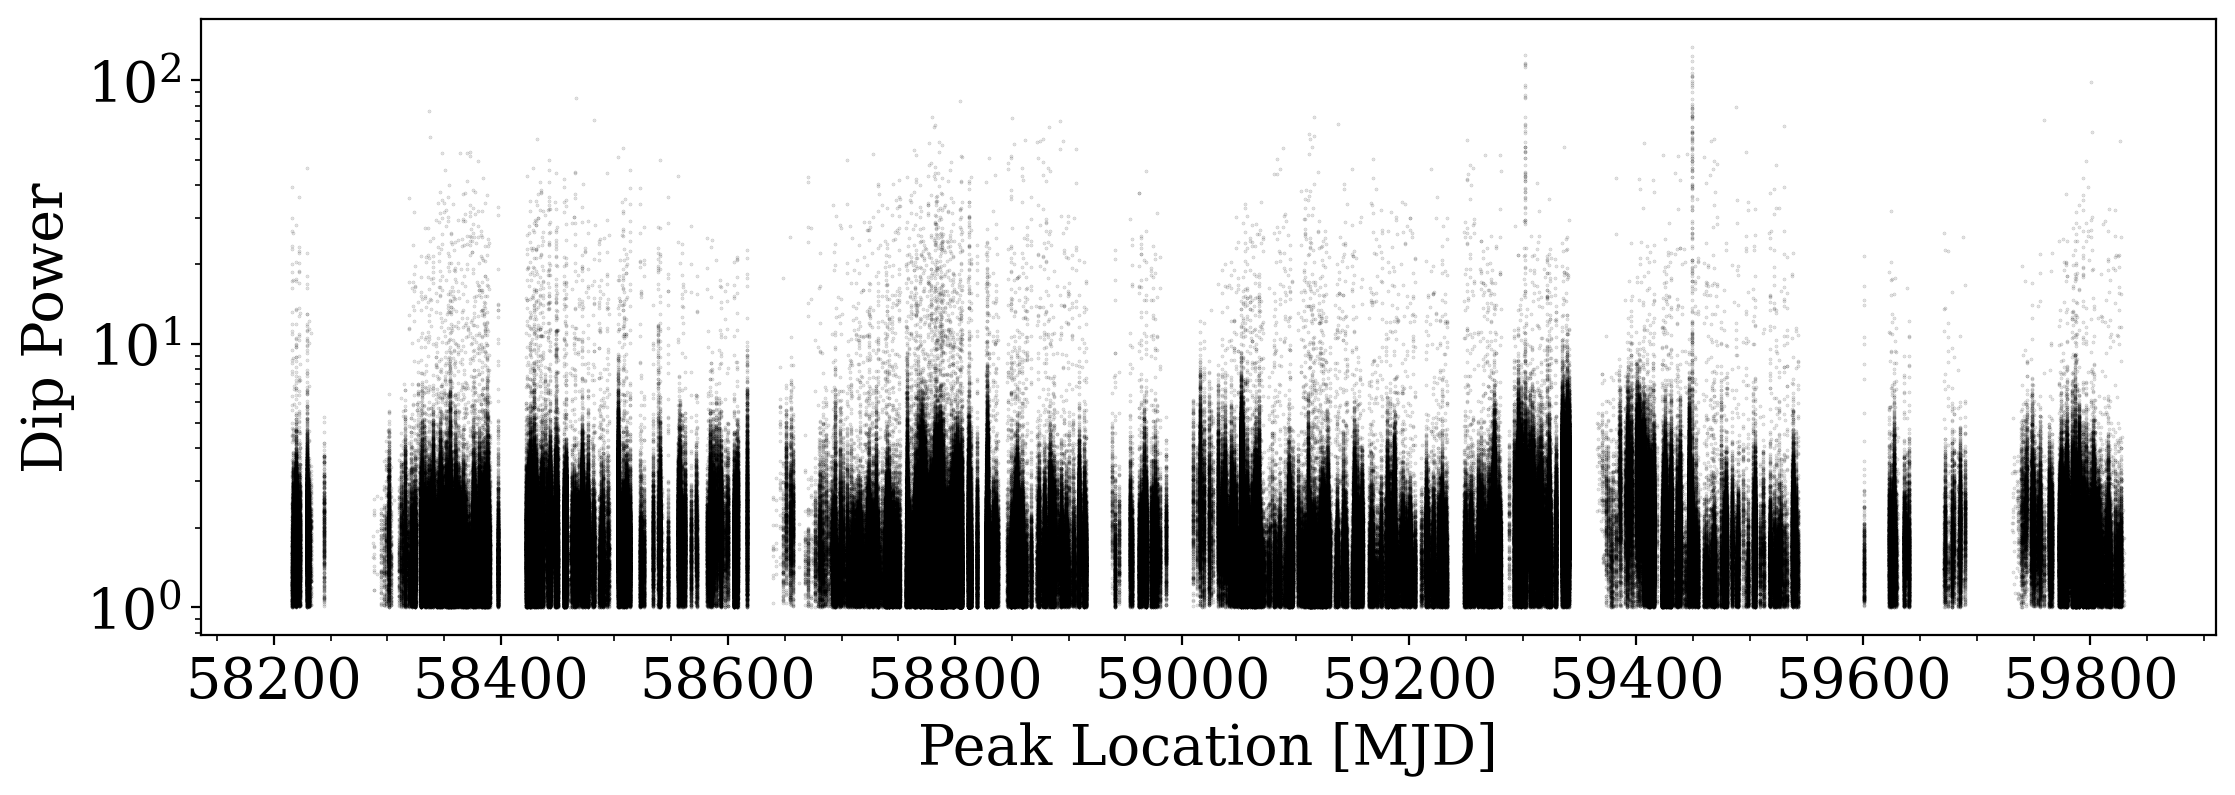

In [259]:
plt.figure(figsize=(13, 4))
plt.scatter(xloc, ypow,
            s=0.1, color='k', alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')


(-59.7, 0.0)

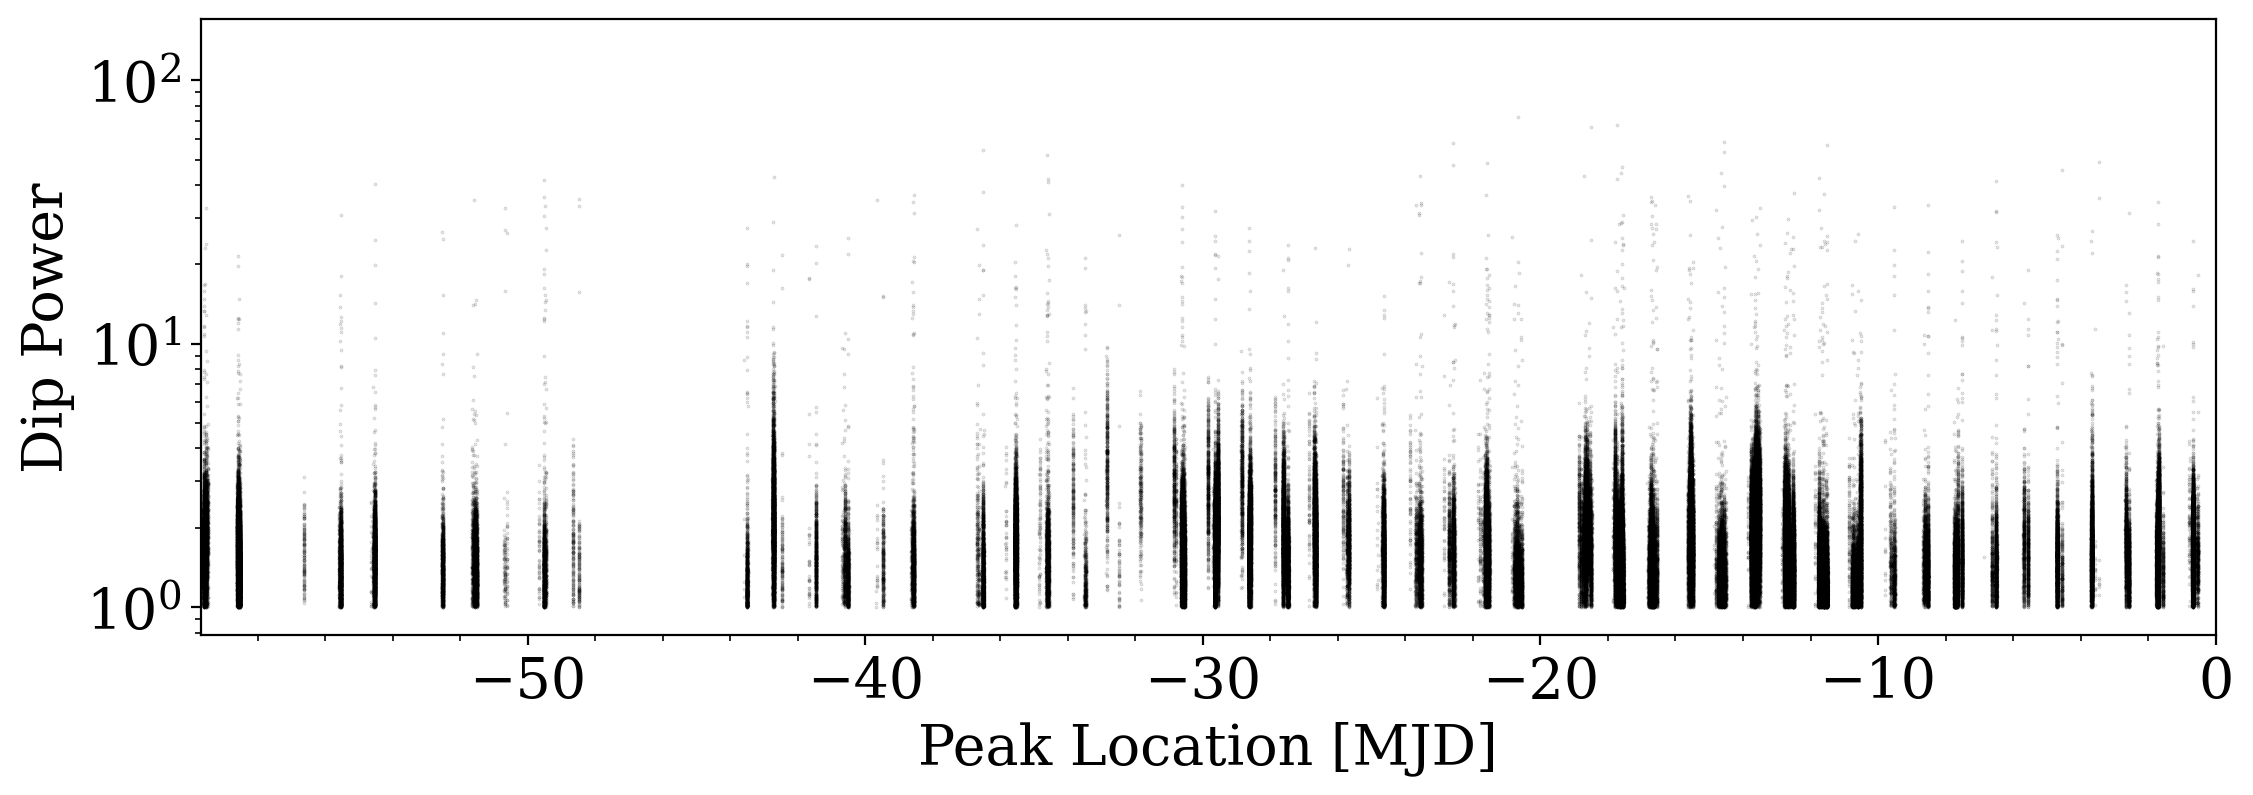

In [368]:
plt.figure(figsize=(13, 4))
plt.scatter(xloc-58800, ypow,
            s=0.1, color='k', alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')
plt.xlim(-59.7, 0)


In [211]:
from astropy.timeseries import LombScargle

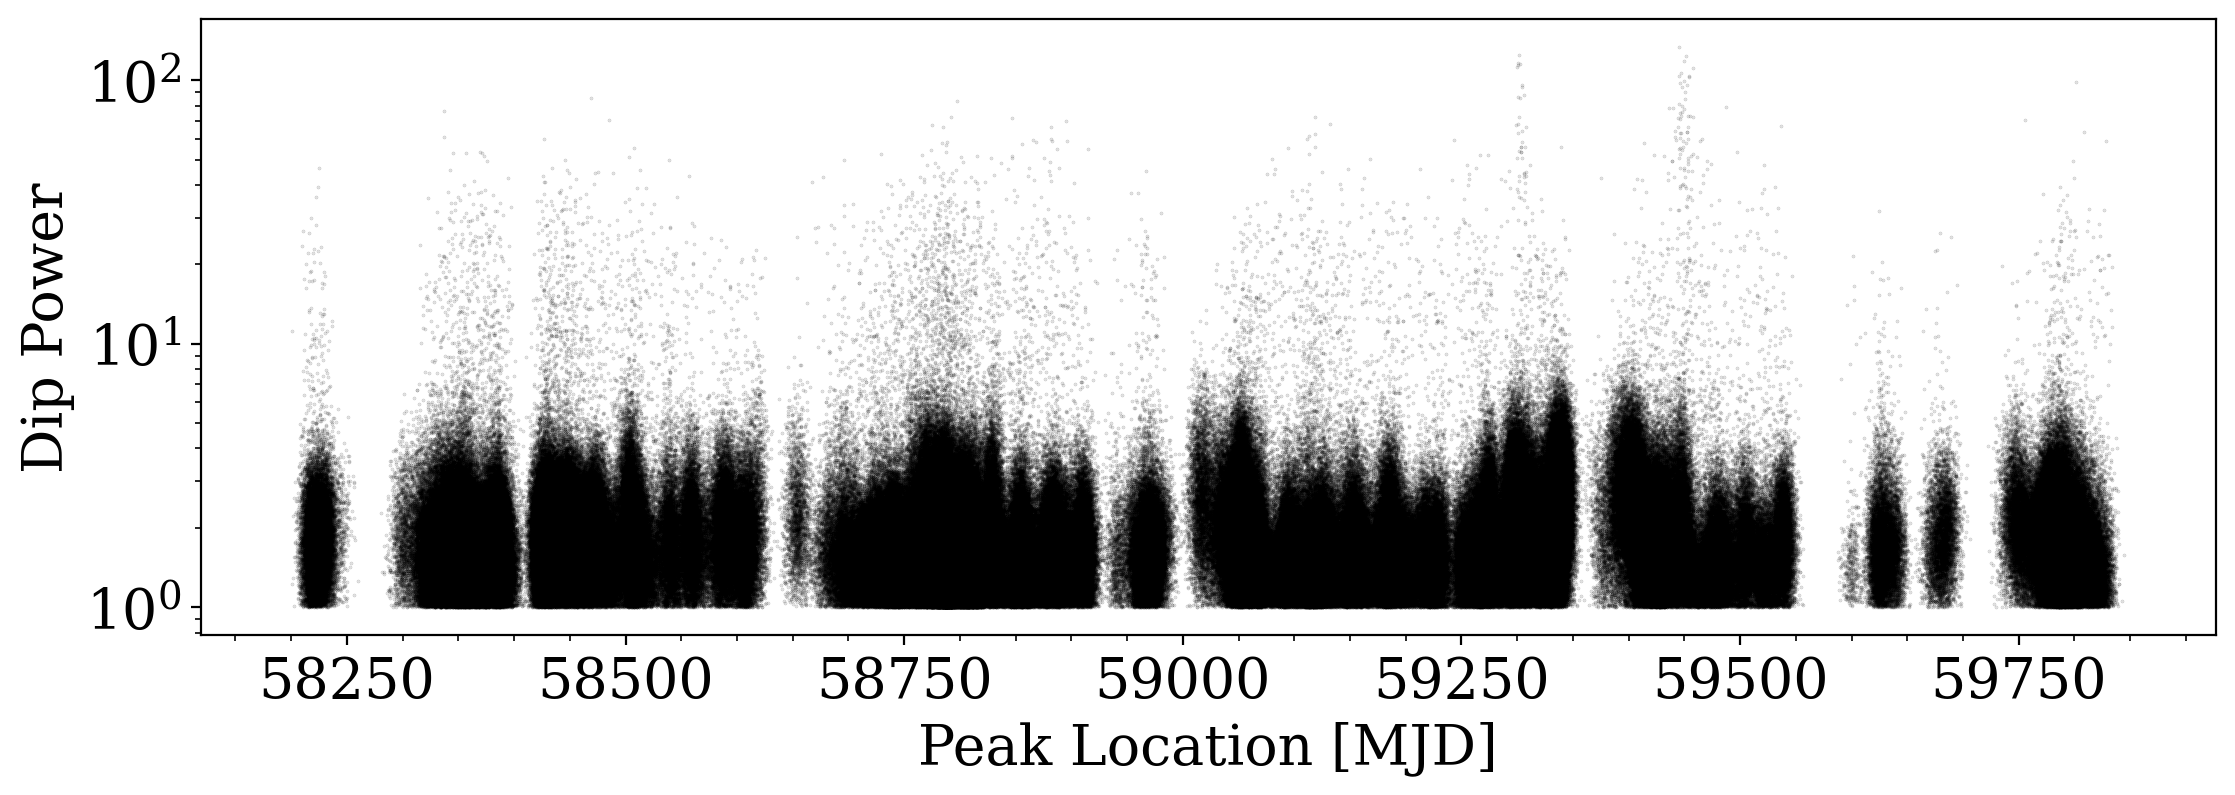

In [358]:
plt.figure(figsize=(13, 4))
plt.scatter(xloc+np.random.normal(0, 5, len(xloc)),
            (ypow),
            s=0.1, color='k', alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')


In [241]:
frequency, power = LombScargle(xloc, ypow).autopower()

In [242]:
frequency2, power2 = LombScargle(xloc+np.random.normal(0, 10, len(xloc)), 
                                 ypow).autopower()

Text(0, 0.5, 'LSP Power')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


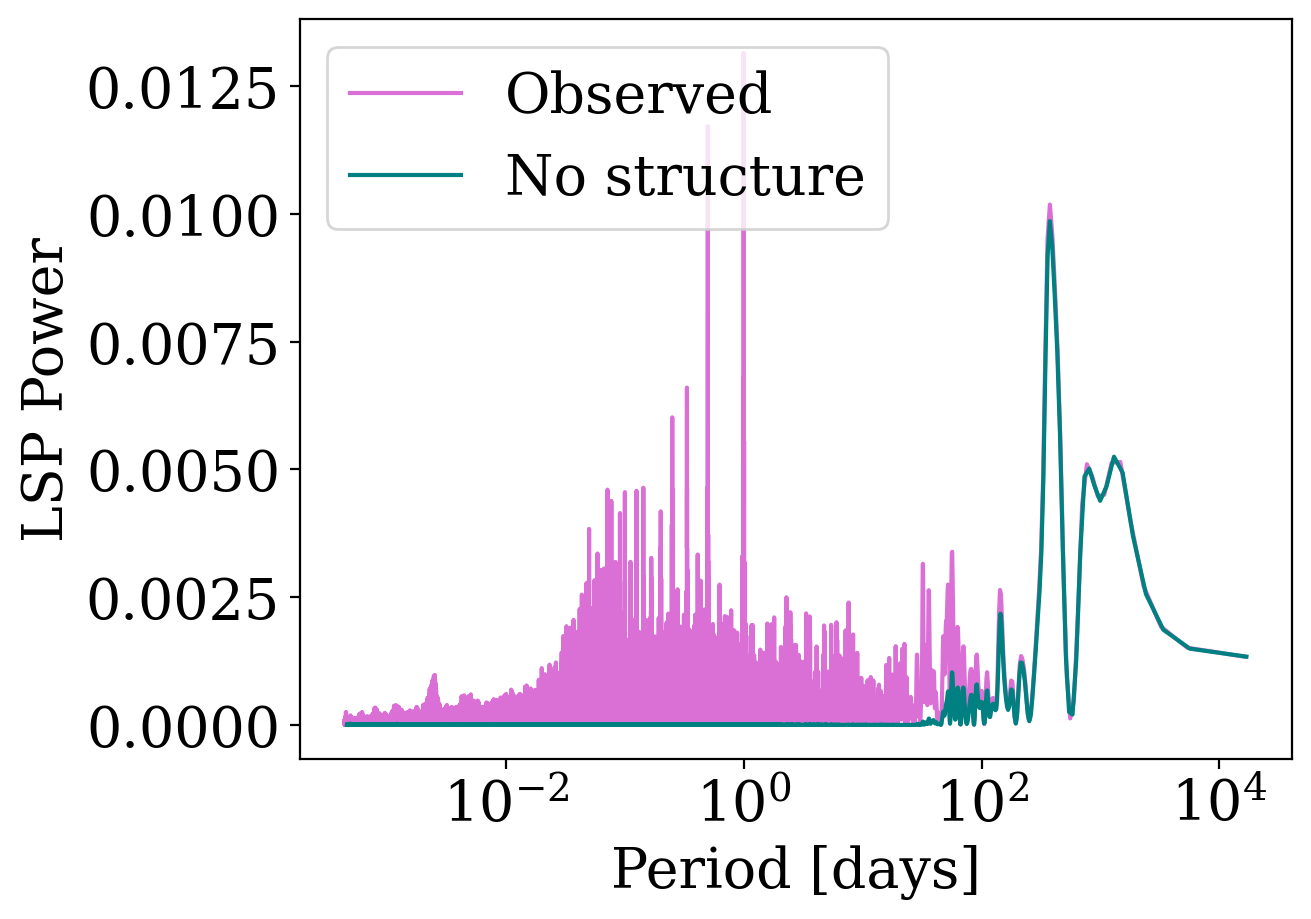

In [243]:
plt.plot(1/frequency, power, color='orchid', label='Observed')
plt.plot(1/frequency2, power2, color='teal', label='No structure')
plt.xscale('log')
plt.legend()
plt.xlabel("Period [days]")
plt.ylabel("LSP Power")

In [244]:
frequency[np.argmax(power)]

1.0026991120438322

In [375]:
N, bbx = np.histogram(xloc, 
             bins=np.arange(round(min(xloc))-1, 
                            round(max(xloc))+1,
                            step=0.041666667))

Text(0.5, 0, 'Dip Loc [MJD]')

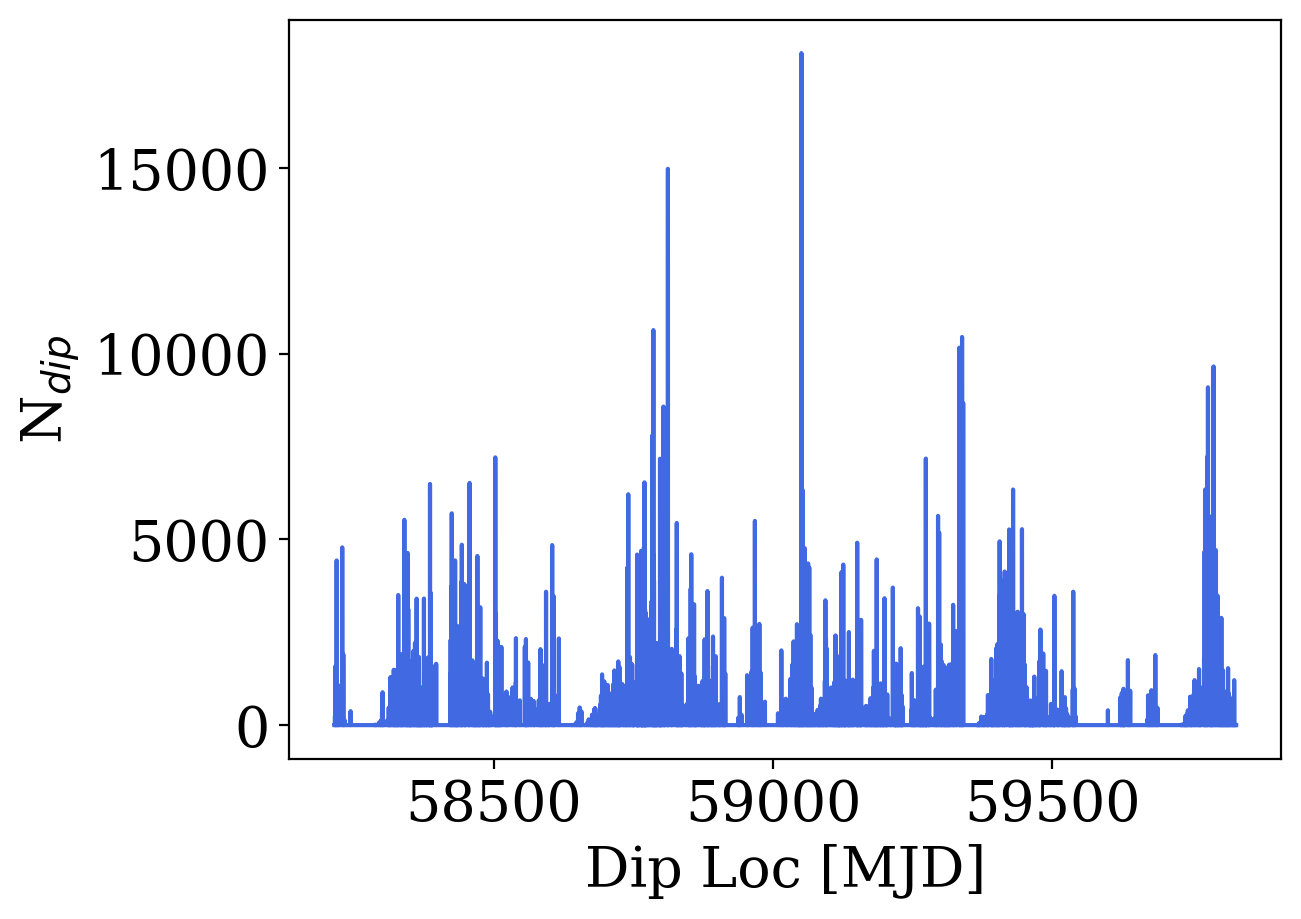

In [376]:
plt.plot(bbx[1::]-1, N, color='royalblue')

plt.ylabel("N$_{dip}$")
plt.xlabel("Dip Loc [MJD]")



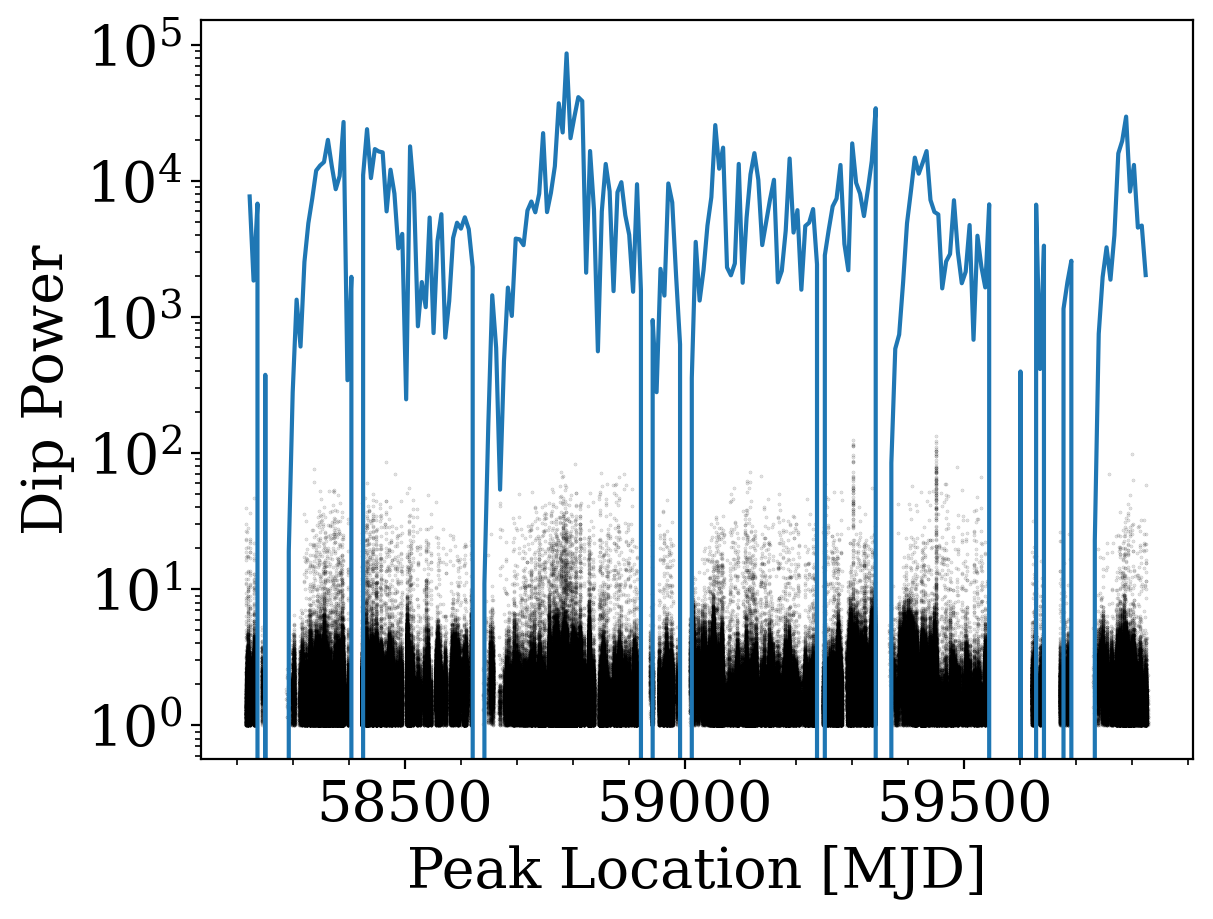

In [329]:
plt.plot(bbx[1::], N)
plt.scatter(xloc, ypow,
            s=0.1, 
            color='k',
            alpha=0.2)

plt.minorticks_on()
plt.ylabel("Dip Power")
plt.xlabel("Peak Location [MJD]")
plt.yscale('log')


In [447]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=0.01, color='k', alpha=0.1)
    ax.set_xlim(min(x)-50, max(x)+50)
    ax.set_yscale('log')
    ax.set_ylim(0)
    ax.set_xlabel("$\mu_{loc}$ [MJD]")
    ax.set_ylabel("Dip Deviation")
    ax.set_ylim(1, 50)
    
    # now determine nice limits by hand:
    binwidth = 10
    xymax = max(np.max(np.abs(x)), 20)
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=np.arange(min(x)-1, max(x)+1,
                                   step=5), color='k', histtype='stepfilled')
    
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['left'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)


    #ax_histx.yaxis.set_ticks_position('left')
    #ax_histx.xaxis.set_ticks_position('right')
    
    
    ax_histy.hist((y[y<10]), bins=2_000, orientation='horizontal', histtype='stepfilled',
                 color='k')
    ax_histy.set_yscale('log')

<>:11: DeprecationWarning: invalid escape sequence '\m'
<>:11: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_96059/3691576906.py:11: DeprecationWarning: invalid escape sequence '\m'
  ax.set_xlabel("$\mu_{loc}$ [MJD]")


/tmp/ipykernel_96059/3691576906.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0)


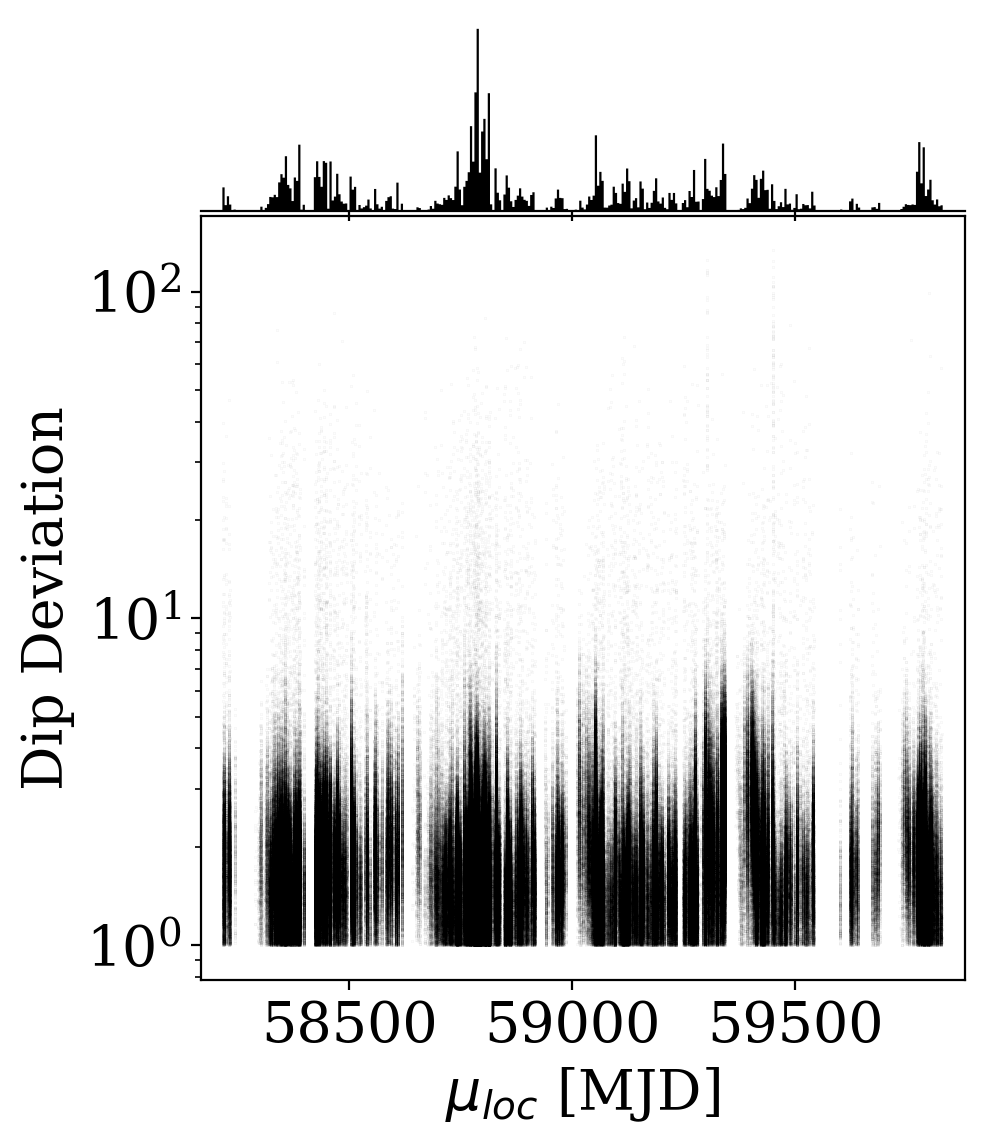

In [448]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.01, hspace=0.01)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
#ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histy.set_yticks([])
ax_histx.set_yticks([])


# Draw the scatter plot and marginals.
scatter_hist(xloc, ypow, ax, ax_histx, ax_histy)
